In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import ensemble

In [2]:
data_raw=pd.read_csv('train.csv')

In [3]:
#Load dataset
data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
y=data['SalePrice']
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Fill 'NA'

In [4]:
#How many 'NA' do we have in?
data.isnull().sum().sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

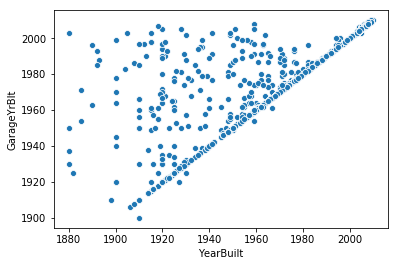

In [5]:
sns.scatterplot(data.YearBuilt, data.GarageYrBlt)

In [6]:
#Delliting columns with big amount NA values
data=data.drop(['PoolQC', 'MiscFeature'],axis=1)
test=test.drop(['PoolQC', 'MiscFeature'],axis=1)

#Categorical data where 'NA' it's like category 'No Garage' or 'No Basment'
NA_list=['Alley', 'Fence', 'FireplaceQu', 'GarageType','GarageCond','GarageQual','GarageFinish','BsmtFinType2',
         'BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1','MasVnrType']
data[NA_list]=data[NA_list].fillna('na')
test[NA_list]=test[NA_list].fillna('na')

# I don't use GarageYrBlt because it corelates with "YearBuilt"
data=data.drop('GarageYrBlt', axis=1)
test=test.drop('GarageYrBlt', axis=1)

# 'Electrical' - fillna most frequent value
ind=data[data['Electrical'].isnull()==True].index
data.loc[ind,'Electrical']=data['Electrical'].value_counts().keys()[0]
test.loc[ind,'Electrical']=test['Electrical'].value_counts().keys()[0]

#'LotFrontage' fill 'NA' - 0
data['LotFrontage']=data['LotFrontage'].fillna(0)
test['LotFrontage']=test['LotFrontage'].fillna(0)
# create new feature LotFrontage_01
data['LotFrontage_01']=[1 if i>0 else 0 for i in data['LotFrontage'] ]
test['LotFrontage_01']=[1 if i>0 else 0 for i in test['LotFrontage'] ]

#MasVnrArea fill 'NA' - 0
ind_train=data[['MasVnrArea','MasVnrType','SalePrice']][data['MasVnrArea'].isnull()==True].index
ind_test=test[['MasVnrArea','MasVnrType']][test['MasVnrArea'].isnull()==True].index
data.loc[ind_train,'MasVnrArea']=0
test.loc[ind_test,'MasVnrArea']=0

In [7]:
#Checking 'NA' in train dataset
features_na=data.isnull().sum().sort_values(ascending=False)
features_na[features_na>0]

Series([], dtype: int64)

In [8]:
#Let's check 'NA' in test dataset
features_na=test.isnull().sum().sort_values(ascending=False)
features_na[features_na>0]

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
GarageArea      1
BsmtFinSF2      1
BsmtUnfSF       1
Exterior2nd     1
Exterior1st     1
KitchenQual     1
GarageCars      1
TotalBsmtSF     1
BsmtFinSF1      1
SaleType        1
dtype: int64

In [9]:
#Data type of missing data
test.dtypes[features_na[features_na>0].index]

MSZoning         object
Functional       object
BsmtFullBath    float64
BsmtHalfBath    float64
Utilities        object
GarageArea      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
Exterior2nd      object
Exterior1st      object
KitchenQual      object
GarageCars      float64
TotalBsmtSF     float64
BsmtFinSF1      float64
SaleType         object
dtype: object

In [10]:
#Fill 'NA' by more frequent value in feature: Functional, Utilities, SaleType, Exterior2nd, Exterior1st, KitchenQual
#Fill 'NA' by zero: BsmtFullBath,BsmtFinSF2,BsmtFinSF2,BsmtUnfSF,GarageCars,GarageArea,TotalBsmtSF,BsmtFinSF1
for i in ['Functional', 'Utilities', 'SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual']:
    test.loc[test[test[i].isnull()==True].index,i]=test[i].value_counts().keys()[0]
for i in ['BsmtFullBath','BsmtFinSF2','BsmtFinSF2','BsmtUnfSF','GarageCars','GarageArea','TotalBsmtSF','BsmtFinSF1','BsmtHalfBath']:
    test.loc[test[test[i].isnull()==True].index,i]=0

In [11]:
#'MSZoning', corelate with neighborhood. You can see it later
#index for filling
ind_IDOTRR=test[['Neighborhood','MSZoning']][test['MSZoning'].isnull()==True][test['Neighborhood']=='IDOTRR'].index
ind_Mitchel=test[['Neighborhood','MSZoning']][test['MSZoning'].isnull()==True][test['Neighborhood']=='Mitchel'].index

val_IDOTRR=test[['Neighborhood','MSZoning']][test['Neighborhood']=='IDOTRR']['MSZoning'].value_counts().keys()[0]
val_Mitchel=test[['Neighborhood','MSZoning']][test['Neighborhood']=='Mitchel']['MSZoning'].value_counts().keys()[0]

test.loc[ind_IDOTRR,'MSZoning']=val_IDOTRR
test.loc[ind_Mitchel,'MSZoning']=val_Mitchel

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [12]:
#Checking 'NA' for test dataset
features_na=test.isnull().sum().sort_values(ascending=False)
features_na[features_na>0]

Series([], dtype: int64)

## Feature impotance analysis

In [13]:
#Split features on categorical and numerical
categorical=[i for i in data.columns if data.dtypes[i]=='object']
numerical=[i for i in data.columns if data.dtypes[i]!='object']

### Numerical features analysis

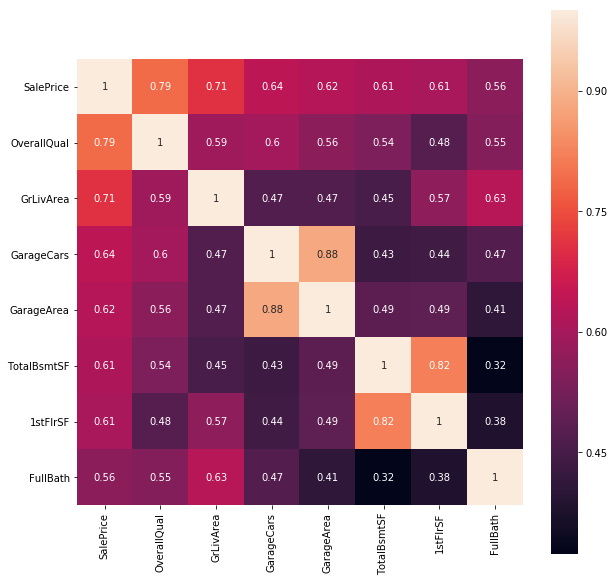

In [17]:
corr_matrix=data[numerical].corr()
cols=corr_matrix.nlargest(8,'SalePrice')['SalePrice'].index
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix.loc[cols,cols],annot=True,square=True)
best_num_cols=cols

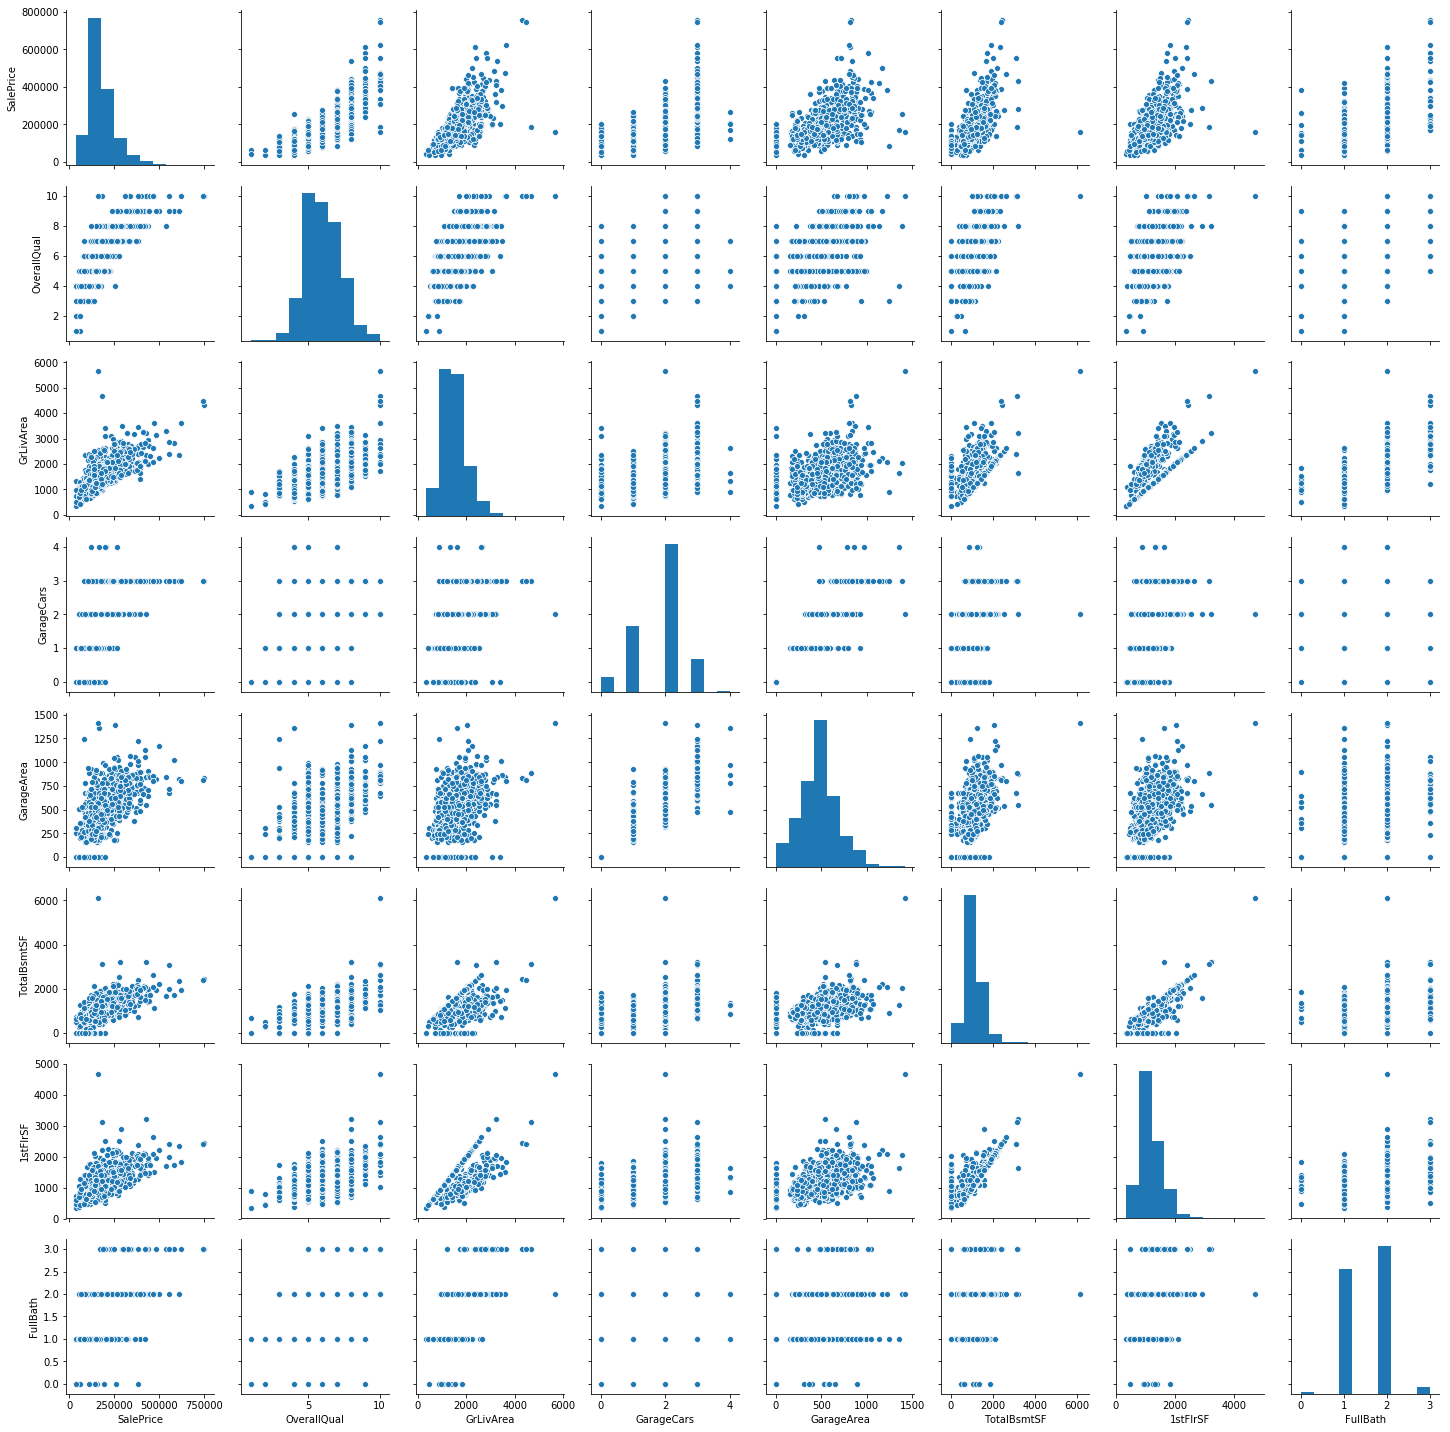

In [18]:
sns.pairplot(data[best_num_cols])

Deleting features that corelate to each other
- GrLivArea: Above grade (ground) living area square feet / TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

- 'GarageArea'/ 'GarageCars'

In [ ]:
#? TotalBsmtSF: Total square feet of basement area / 1stFlrSF: First Floor square feet

In [19]:
#Deleting features that corelate to each other
# high corelation
cor_features=['TotRmsAbvGrd', 'GarageArea','SalePrice']
features_for_model_num=[i for i in best_num_cols if i not in cor_features]

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


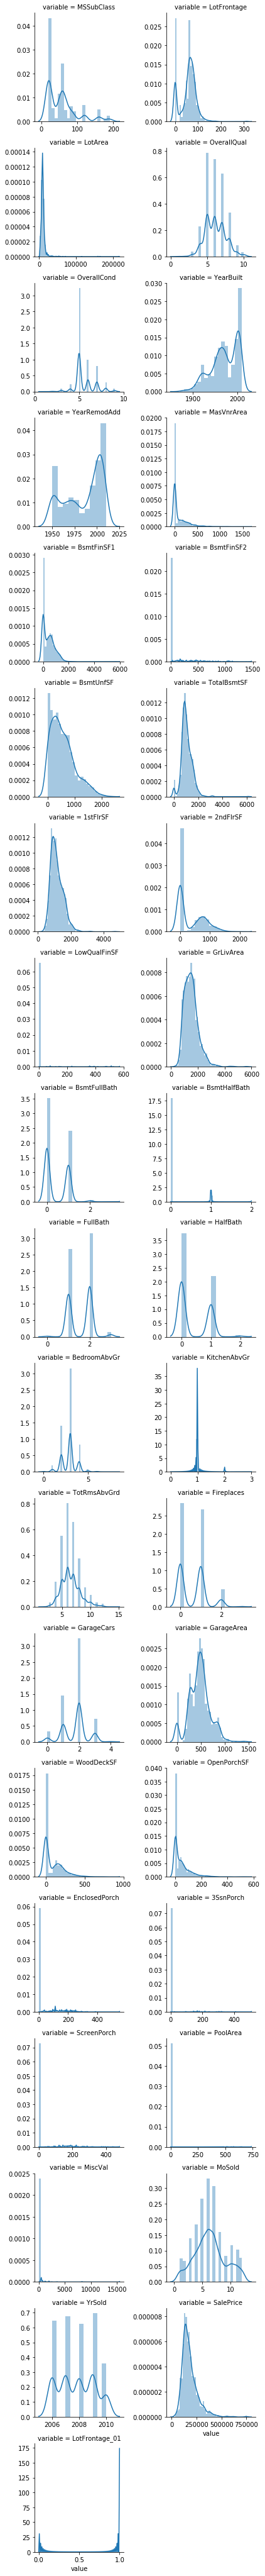

In [20]:
f=pd.melt(data,value_vars=numerical[1:])
g=sns.FacetGrid(f,col='variable',col_wrap=2,sharex=False, sharey=False)
g.map(sns.distplot,'value')

In [21]:
def feature_normalization(X,cols):
    X_copy=X.copy()
    for i in cols:
        X_copy[i]=np.log1p(X_copy[i])
    return X_copy

In [22]:
#cols_for_log=['TotalBsmtSF', '2ndFlrSF', 'GrLivArea','1stFlrSF','LotArea']
cols_for_log=['LotFrontage','LotArea', 'TotalBsmtSF','1stFlrSF','2ndFlrSF', 'GrLivArea','GarageArea']

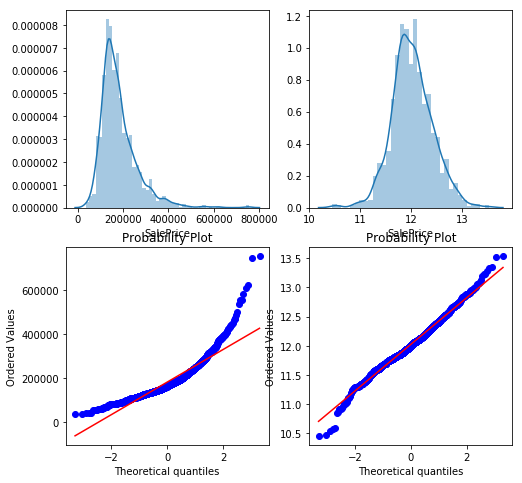

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.distplot(y)
plt.subplot(2,2,2)
sns.distplot(np.log(y))
plt.subplot(2,2,3)
stats.probplot(y, plot=plt)
plt.subplot(2,2,4)
stats.probplot(np.log(y), plot=plt)
plt.show()

In [24]:
#Lorarithm of some features
data=feature_normalization(data,cols=cols_for_log)
test=feature_normalization(test,cols=cols_for_log)

### Outlairs

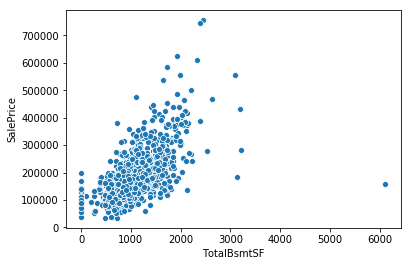

In [25]:
sns.scatterplot(data_raw['TotalBsmtSF'],y)

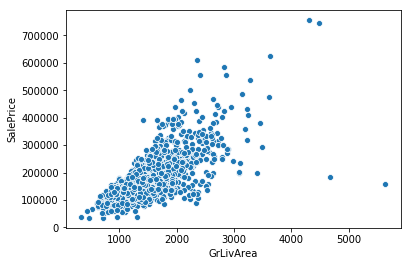

In [26]:
sns.scatterplot(data_raw['GrLivArea'],y)

In [27]:
#cols_for_dropping_outliars=['TotalBsmtSF','GrLivArea']

ind_TotalBsmtSF=data['TotalBsmtSF'][data['TotalBsmtSF']>5000].index
ind_GrLivArea=data['GrLivArea'][data['GrLivArea']>4500].index
ind_for_drop=np.unique(np.concatenate((ind_TotalBsmtSF, ind_GrLivArea)))
data=data.drop(ind_for_drop, axis=0)

### Categorical features analysis

In [32]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

E:\Anaconda\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


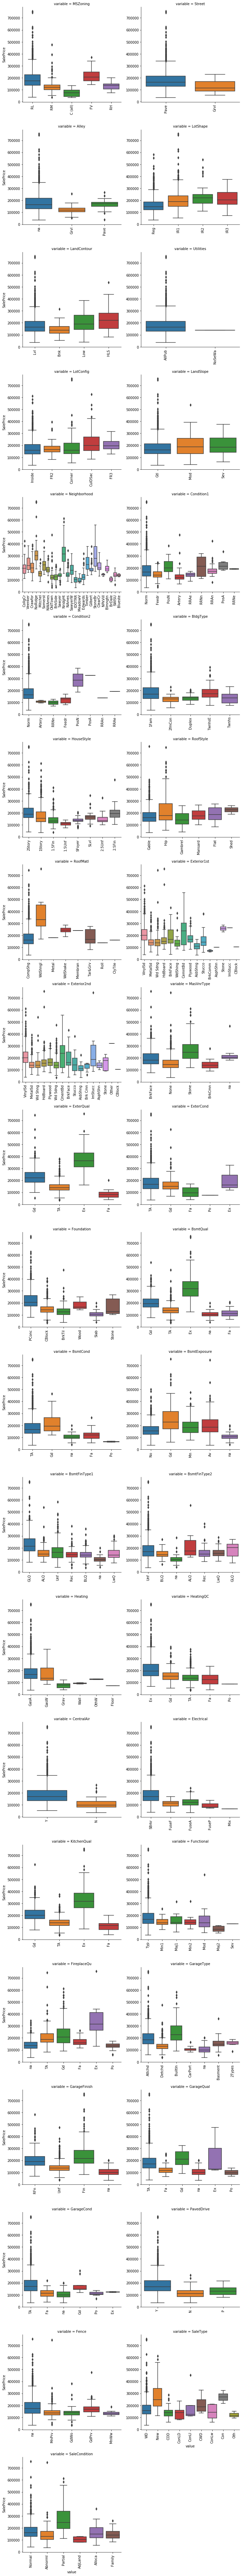

In [33]:

f=pd.melt(data,id_vars=['SalePrice'],value_vars=categorical)
g=sns.FacetGrid(f, col='variable', col_wrap=2,  sharex=False, sharey=False, size=5)
g=g.map(boxplot, 'value', 'SalePrice')

In [34]:
#Analysis categorical features
pvals=[]
for i in categorical:
    samples=[]
    for j in data[i].unique():
        s=data[data[i]==j]['SalePrice'].values
        samples.append(s)
    p=stats.f_oneway(*samples)[1]
    pvals.append(p)

F=pd.DataFrame()
F['features']=categorical
F['pvalue']=pvals
F['impotance']=np.log(1/F.pvalue)
F.sort_values('pvalue')[:15]

,features,pvalue,impotance
8,Neighborhood,1.558600e-225,517.637858
18,ExterQual,1.439551e-204,469.363028
21,BsmtQual,8.158548e-196,449.207612
30,KitchenQual,3.032213e-192,440.987045
34,GarageFinish,6.228747e-115,262.968110
32,FireplaceQu,2.971217e-107,245.287633
20,Foundation,5.791895e-91,207.778784
33,GarageType,6.117026e-87,198.513827
24,BsmtFinType1,2.386358e-71,162.613773
27,HeatingQC,2.667062e-67,153.292224


In [35]:
def encode(feature,data):
    FF=pd.DataFrame()
    FF['val']=data[feature].fillna('na').unique()
    FF.index=FF.val
    FF['spmean']=data[[feature,'SalePrice']].fillna('na').groupby(feature).mean()['SalePrice']
    FF=FF.sort_values('spmean')
    FF['ordering']=range(1,FF.shape[0]+1)
    D=FF['ordering'].to_dict()
    for cat,order in D.items():
        data.loc[data[feature].fillna('na')==cat, feature+'_E'] = order
    return D

In [36]:
cat_encoded=[]
for i in categorical:
    D=encode(i,data)
    test[i+'_E']=[D[j] for j in test[i]]
    cat_encoded.append(i+'_E')

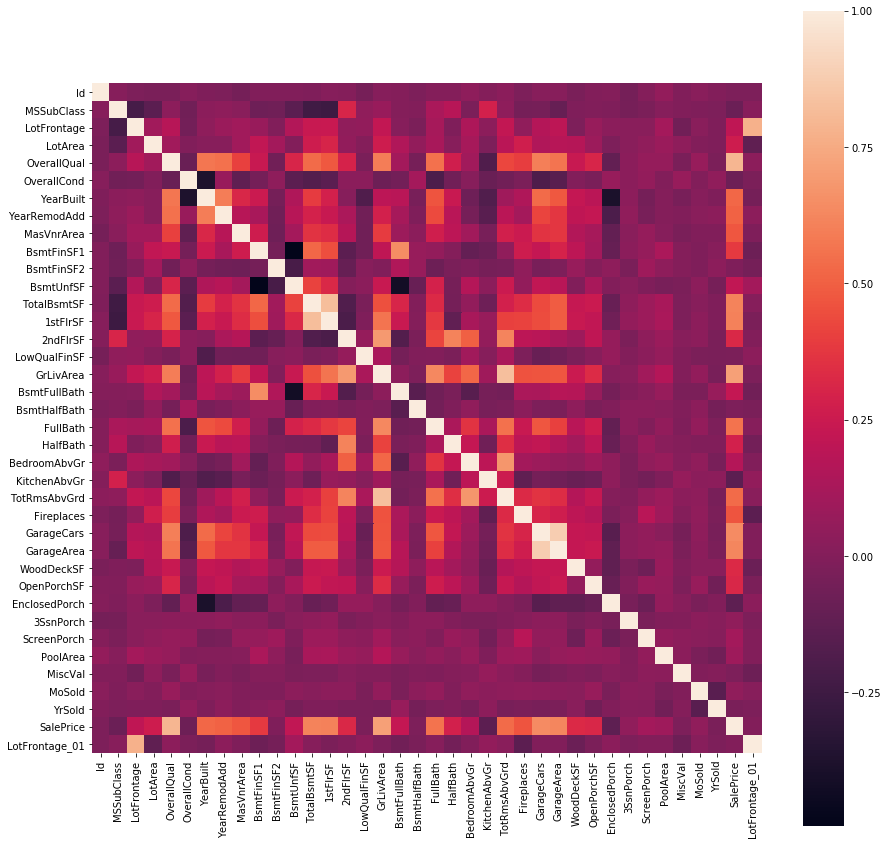

In [37]:
cat_encoded_price=cat_encoded.copy()
cat_encoded_price.append('SalePrice')
corr_matrix_cat=data[cat_encoded_price].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix,square=True)

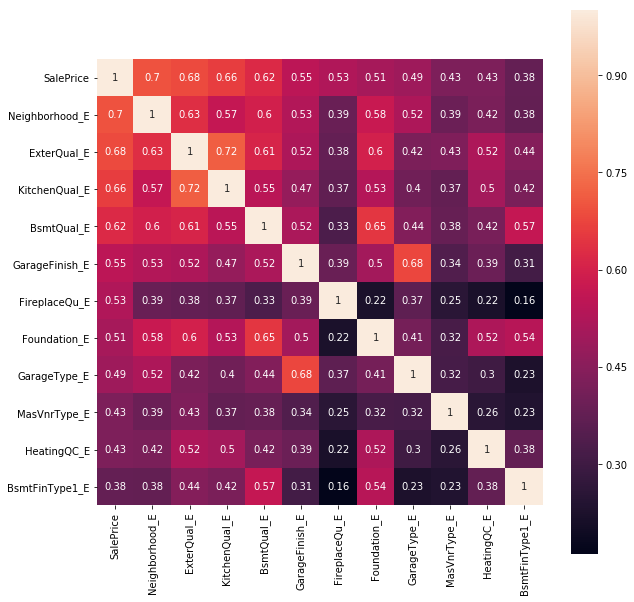

In [38]:
best_features_cat=corr_matrix_cat['SalePrice'].sort_values(ascending=False)[corr_matrix_cat['SalePrice']>=0.38].index
corr_matrix_cat_best=data[best_features_cat].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix_cat_best, square=True,annot=True)

### Adding yes/no features

In [39]:
features_yn=['TotalBsmtSF', 'GarageArea', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']
def add_yn(data, features_yn=features_yn):
    for f in features_yn:
        data[f+'_']=[1 if i>0 else 0 for i in data[f] ]

In [40]:
add_yn(data, features_yn=features_yn)
add_yn(test, features_yn=features_yn)

## Buiding model

In [41]:
def start_model(train, y, estimator=linear_model.Ridge(alpha=1,random_state=10)):
    estimator.fit(train,y)
    predict=estimator.predict(train)
    print(f"MAE={cross_val_score(estimator,train,y,cv=5,scoring='neg_mean_absolute_error').mean()}")
    print(f"RMSE = {np.sqrt(np.abs(cross_val_score(estimator,train,y,cv=5,scoring='neg_mean_squared_error').mean()))}")
    print(f'Metric RMSE = {np.sqrt(metrics.mean_squared_error(y,estimator.predict(train)))}')
    return estimator
          
def save_submmisions(estimator, test, name='submission.csv',ind_id=test.Id):
    predictins=estimator.predict(test)
    submission=pd.DataFrame()
    submission['Id']=ind_id
    submission['SalePrice']=np.exp(predictins)
    submission.to_csv(name,index=False)

In [42]:
numerical.remove('Id')
numerical.remove('SalePrice')

In [43]:
y_=np.log(y)
estimator = start_model(data[numerical+cat_encoded+features_yn], y_,estimator=linear_model.Ridge(alpha=1,random_state=10))

MAE=-0.0887329610838406
RMSE = 0.13382749759751408
Metric RMSE = 0.11868797653313595


In [44]:
y_=np.log(y)
estimator = start_model(data[numerical+cat_encoded+features_yn], 
                        y_, estimator=ensemble.GradientBoostingRegressor(random_state=10))

MAE=-0.08608786292953846
RMSE = 0.12435217161316353
Metric RMSE = 0.08024203416128033


In [ ]:
#save_submmisions(estimator, test[numerical+cat_encoded+features_yn], name='submission_all_final.csv',ind_id=test.Id)

In [45]:
%%html
<img src="score.png" style="height:140px">